# Our final model

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.23.4


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.0


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


In [7]:
from tensorflow import keras
print(keras.__version__)

2.1.6-tf


## Loading and preparing our data set for classification

In [8]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 26800  100 26800    0     0  81707      0 --:--:-- --:--:-- --:--:-- 81707


In [9]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')
y=df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

In [10]:
df.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [11]:
df.describe()

,speed,age,miles
count,1500.000000,1500.000000,1500.000000
mean,122.492667,44.952667,30.344000
std,17.604333,17.191727,15.463152
min,68.000000,9.000000,-21.000000
25%,108.000000,32.000000,18.000000
50%,120.000000,42.000000,29.000000
75%,137.000000,55.000000,42.000000
max,166.000000,102.000000,84.000000


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [15]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data, xlim=None, ylim=None):
    h = 1  # step size in the mesh
    if xlim == None:
        xlim = x_data.min(), x_data.max()
    if ylim == None:
        ylim = y_data.min(), y_data.max()
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.arange(x_min - 1, x_max + 1, h),
                         np.arange(y_min - 1, y_max + 1, h))
    return xx, yy, xlim, ylim
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False, xlim=(16, 90), ylim=(70, 170)):
    xx,yy, xlim, ylim = meshGrid(x_data, y_data, xlim, ylim)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)
                
def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_

## Almost all real-life scenarios have many more than 2 inputs
* With more than 2 input features plotting decision boundaries does not make much sense any more
* From now on we work with 3 features and only rely on accuracy measures

In [16]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

num_categories = 3
dropout = 0.6
model = keras.Sequential()

model.add(Dense(100, name='hidden1', input_dim=3))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(100, name='hidden2'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(dropout))

model.add(Dense(num_categories, name='softmax', activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 100)               400       
_________________________________________________________________
batch_normalization (BatchNo (None, 100)               400       
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
hidden2 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
__________

### We also limit the number of epochs further to 2000 (because we have seen that after that nothing good is going to happen)

In [17]:
BATCH_SIZE=1000
EPOCHS = 2000

%time history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2)

Train on 720 samples, validate on 180 samples
Epoch 1/2000
720/720 [==============================] - 1s 2ms/step - loss: 1.5846 - acc: 0.3486 - val_loss: 8.3775 - val_acc: 0.3278
Epoch 2/2000
720/720 [==============================] - 0s 15us/step - loss: 1.6486 - acc: 0.3181 - val_loss: 9.0708 - val_acc: 0.3278
Epoch 3/2000
720/720 [==============================] - 0s 15us/step - loss: 1.4792 - acc: 0.3597 - val_loss: 9.6268 - val_acc: 0.3278
Epoch 4/2000
720/720 [==============================] - 0s 14us/step - loss: 1.4627 - acc: 0.3722 - val_loss: 9.9266 - val_acc: 0.3278
Epoch 5/2000
720/720 [==============================] - 0s 12us/step - loss: 1.4732 - acc: 0.3458 - val_loss: 10.0840 - val_acc: 0.3278
Epoch 6/2000
720/720 [==============================] - 0s 14us/step - loss: 1.3673 - acc: 0.3833 - val_loss: 10.1918 - val_acc: 0.3278
Epoch 7/2000
720/720 [==============================] - 0s 15us/step - loss: 1.3075 - acc: 0.3958 - val_loss: 10.2181 - val_acc: 0.3278
Epoch 8

Epoch 61/2000
720/720 [==============================] - 0s 13us/step - loss: 0.8575 - acc: 0.6111 - val_loss: 2.7694 - val_acc: 0.4833
Epoch 62/2000
720/720 [==============================] - 0s 12us/step - loss: 0.9230 - acc: 0.6083 - val_loss: 2.7460 - val_acc: 0.4778
Epoch 63/2000
720/720 [==============================] - 0s 13us/step - loss: 0.8980 - acc: 0.5944 - val_loss: 2.7245 - val_acc: 0.4833
Epoch 64/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8963 - acc: 0.5889 - val_loss: 2.7024 - val_acc: 0.4889
Epoch 65/2000
720/720 [==============================] - 0s 12us/step - loss: 0.9037 - acc: 0.6306 - val_loss: 2.6797 - val_acc: 0.4833
Epoch 66/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8758 - acc: 0.6236 - val_loss: 2.6576 - val_acc: 0.4833
Epoch 67/2000
720/720 [==============================] - 0s 11us/step - loss: 0.8901 - acc: 0.6306 - val_loss: 2.6371 - val_acc: 0.4889
Epoch 68/2000
720/720 [=========================

720/720 [==============================] - 0s 11us/step - loss: 0.7545 - acc: 0.6750 - val_loss: 1.5469 - val_acc: 0.4833
Epoch 122/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7765 - acc: 0.6944 - val_loss: 1.5337 - val_acc: 0.4889
Epoch 123/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7727 - acc: 0.6847 - val_loss: 1.5206 - val_acc: 0.4889
Epoch 124/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7967 - acc: 0.6389 - val_loss: 1.5096 - val_acc: 0.4889
Epoch 125/2000
720/720 [==============================] - 0s 12us/step - loss: 0.8094 - acc: 0.6653 - val_loss: 1.4991 - val_acc: 0.4833
Epoch 126/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7852 - acc: 0.6694 - val_loss: 1.4898 - val_acc: 0.4889
Epoch 127/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7892 - acc: 0.6667 - val_loss: 1.4815 - val_acc: 0.4889
Epoch 128/2000
720/720 [==============================] 

Epoch 181/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7495 - acc: 0.6792 - val_loss: 0.9558 - val_acc: 0.5944
Epoch 182/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7527 - acc: 0.7042 - val_loss: 0.9475 - val_acc: 0.5944
Epoch 183/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7293 - acc: 0.7083 - val_loss: 0.9403 - val_acc: 0.6000
Epoch 184/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7633 - acc: 0.6944 - val_loss: 0.9328 - val_acc: 0.6056
Epoch 185/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7281 - acc: 0.6972 - val_loss: 0.9259 - val_acc: 0.6111
Epoch 186/2000
720/720 [==============================] - 0s 12us/step - loss: 0.7984 - acc: 0.6750 - val_loss: 0.9200 - val_acc: 0.6111
Epoch 187/2000
720/720 [==============================] - 0s 10us/step - loss: 0.7527 - acc: 0.6958 - val_loss: 0.9151 - val_acc: 0.6167
Epoch 188/2000
720/720 [=================

Epoch 241/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7082 - acc: 0.7181 - val_loss: 0.7057 - val_acc: 0.7167
Epoch 242/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7348 - acc: 0.6958 - val_loss: 0.7046 - val_acc: 0.7167
Epoch 243/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7292 - acc: 0.6972 - val_loss: 0.7033 - val_acc: 0.7056
Epoch 244/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7510 - acc: 0.7264 - val_loss: 0.7014 - val_acc: 0.7056
Epoch 245/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7078 - acc: 0.7028 - val_loss: 0.6987 - val_acc: 0.7111
Epoch 246/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7004 - acc: 0.7153 - val_loss: 0.6954 - val_acc: 0.7111
Epoch 247/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7460 - acc: 0.7042 - val_loss: 0.6921 - val_acc: 0.7056
Epoch 248/2000
720/720 [=================

Epoch 301/2000
720/720 [==============================] - 0s 36us/step - loss: 0.7292 - acc: 0.7069 - val_loss: 0.6034 - val_acc: 0.7722
Epoch 302/2000
720/720 [==============================] - 0s 31us/step - loss: 0.6985 - acc: 0.7347 - val_loss: 0.6021 - val_acc: 0.7722
Epoch 303/2000
720/720 [==============================] - 0s 36us/step - loss: 0.7061 - acc: 0.6986 - val_loss: 0.6009 - val_acc: 0.7722
Epoch 304/2000
720/720 [==============================] - 0s 14us/step - loss: 0.7136 - acc: 0.7083 - val_loss: 0.6006 - val_acc: 0.7722
Epoch 305/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7138 - acc: 0.7097 - val_loss: 0.6000 - val_acc: 0.7722
Epoch 306/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6971 - acc: 0.7250 - val_loss: 0.5992 - val_acc: 0.7722
Epoch 307/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6787 - acc: 0.7333 - val_loss: 0.5980 - val_acc: 0.7667
Epoch 308/2000
720/720 [=================

Epoch 361/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6832 - acc: 0.7306 - val_loss: 0.5678 - val_acc: 0.8000
Epoch 362/2000
720/720 [==============================] - 0s 13us/step - loss: 0.7029 - acc: 0.7139 - val_loss: 0.5673 - val_acc: 0.8000
Epoch 363/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6885 - acc: 0.7236 - val_loss: 0.5669 - val_acc: 0.8000
Epoch 364/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6895 - acc: 0.7181 - val_loss: 0.5666 - val_acc: 0.8000
Epoch 365/2000
720/720 [==============================] - 0s 11us/step - loss: 0.7071 - acc: 0.7194 - val_loss: 0.5663 - val_acc: 0.8000
Epoch 366/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6861 - acc: 0.7264 - val_loss: 0.5663 - val_acc: 0.8000
Epoch 367/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6868 - acc: 0.7250 - val_loss: 0.5662 - val_acc: 0.8000
Epoch 368/2000
720/720 [=================

Epoch 421/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6970 - acc: 0.7333 - val_loss: 0.5579 - val_acc: 0.8000
Epoch 422/2000
720/720 [==============================] - 0s 31us/step - loss: 0.6877 - acc: 0.7278 - val_loss: 0.5575 - val_acc: 0.8000
Epoch 423/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6682 - acc: 0.7347 - val_loss: 0.5569 - val_acc: 0.8056
Epoch 424/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6518 - acc: 0.7431 - val_loss: 0.5564 - val_acc: 0.8111
Epoch 425/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6904 - acc: 0.7403 - val_loss: 0.5563 - val_acc: 0.8111
Epoch 426/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6768 - acc: 0.7181 - val_loss: 0.5560 - val_acc: 0.8111
Epoch 427/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6862 - acc: 0.7458 - val_loss: 0.5559 - val_acc: 0.8111
Epoch 428/2000
720/720 [=================

Epoch 481/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6844 - acc: 0.7222 - val_loss: 0.5576 - val_acc: 0.8056
Epoch 482/2000
720/720 [==============================] - 0s 24us/step - loss: 0.6764 - acc: 0.7333 - val_loss: 0.5573 - val_acc: 0.8000
Epoch 483/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6475 - acc: 0.7528 - val_loss: 0.5571 - val_acc: 0.7944
Epoch 484/2000
720/720 [==============================] - 0s 26us/step - loss: 0.6569 - acc: 0.7403 - val_loss: 0.5568 - val_acc: 0.7944
Epoch 485/2000
720/720 [==============================] - 0s 40us/step - loss: 0.6416 - acc: 0.7472 - val_loss: 0.5565 - val_acc: 0.7944
Epoch 486/2000
720/720 [==============================] - 0s 29us/step - loss: 0.6904 - acc: 0.7389 - val_loss: 0.5563 - val_acc: 0.8000
Epoch 487/2000
720/720 [==============================] - 0s 35us/step - loss: 0.6709 - acc: 0.7347 - val_loss: 0.5558 - val_acc: 0.7944
Epoch 488/2000
720/720 [=================

Epoch 541/2000
720/720 [==============================] - 0s 42us/step - loss: 0.6364 - acc: 0.7583 - val_loss: 0.5661 - val_acc: 0.7667
Epoch 542/2000
720/720 [==============================] - 0s 31us/step - loss: 0.6405 - acc: 0.7486 - val_loss: 0.5662 - val_acc: 0.7722
Epoch 543/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6676 - acc: 0.7347 - val_loss: 0.5661 - val_acc: 0.7667
Epoch 544/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6672 - acc: 0.7361 - val_loss: 0.5659 - val_acc: 0.7667
Epoch 545/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6522 - acc: 0.7458 - val_loss: 0.5659 - val_acc: 0.7667
Epoch 546/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6652 - acc: 0.7347 - val_loss: 0.5659 - val_acc: 0.7556
Epoch 547/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6425 - acc: 0.7389 - val_loss: 0.5657 - val_acc: 0.7500
Epoch 548/2000
720/720 [=================

Epoch 601/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6559 - acc: 0.7319 - val_loss: 0.5449 - val_acc: 0.7833
Epoch 602/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6641 - acc: 0.7486 - val_loss: 0.5446 - val_acc: 0.7889
Epoch 603/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6494 - acc: 0.7653 - val_loss: 0.5447 - val_acc: 0.7833
Epoch 604/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6697 - acc: 0.7333 - val_loss: 0.5453 - val_acc: 0.7778
Epoch 605/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6232 - acc: 0.7653 - val_loss: 0.5459 - val_acc: 0.7778
Epoch 606/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6750 - acc: 0.7306 - val_loss: 0.5466 - val_acc: 0.7778
Epoch 607/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6836 - acc: 0.7528 - val_loss: 0.5473 - val_acc: 0.7722
Epoch 608/2000
720/720 [=================

Epoch 661/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6539 - acc: 0.7528 - val_loss: 0.5629 - val_acc: 0.7500
Epoch 662/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6513 - acc: 0.7556 - val_loss: 0.5632 - val_acc: 0.7500
Epoch 663/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6483 - acc: 0.7639 - val_loss: 0.5634 - val_acc: 0.7500
Epoch 664/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6770 - acc: 0.7403 - val_loss: 0.5636 - val_acc: 0.7444
Epoch 665/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6363 - acc: 0.7333 - val_loss: 0.5638 - val_acc: 0.7444
Epoch 666/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6244 - acc: 0.7556 - val_loss: 0.5641 - val_acc: 0.7389
Epoch 667/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6320 - acc: 0.7625 - val_loss: 0.5643 - val_acc: 0.7389
Epoch 668/2000
720/720 [=================

Epoch 721/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6203 - acc: 0.7611 - val_loss: 0.5444 - val_acc: 0.7833
Epoch 722/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6492 - acc: 0.7431 - val_loss: 0.5443 - val_acc: 0.7778
Epoch 723/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6510 - acc: 0.7389 - val_loss: 0.5441 - val_acc: 0.7778
Epoch 724/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6234 - acc: 0.7681 - val_loss: 0.5441 - val_acc: 0.7778
Epoch 725/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6406 - acc: 0.7486 - val_loss: 0.5440 - val_acc: 0.7778
Epoch 726/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6443 - acc: 0.7361 - val_loss: 0.5440 - val_acc: 0.7778
Epoch 727/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6471 - acc: 0.7556 - val_loss: 0.5445 - val_acc: 0.7833
Epoch 728/2000
720/720 [=================

Epoch 781/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6397 - acc: 0.7583 - val_loss: 0.5494 - val_acc: 0.7778
Epoch 782/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6357 - acc: 0.7361 - val_loss: 0.5490 - val_acc: 0.7778
Epoch 783/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6311 - acc: 0.7639 - val_loss: 0.5492 - val_acc: 0.7778
Epoch 784/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6372 - acc: 0.7569 - val_loss: 0.5488 - val_acc: 0.7722
Epoch 785/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5992 - acc: 0.7667 - val_loss: 0.5482 - val_acc: 0.7667
Epoch 786/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6279 - acc: 0.7542 - val_loss: 0.5473 - val_acc: 0.7722
Epoch 787/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6536 - acc: 0.7528 - val_loss: 0.5462 - val_acc: 0.7722
Epoch 788/2000
720/720 [=================

Epoch 841/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6288 - acc: 0.7625 - val_loss: 0.5464 - val_acc: 0.7778
Epoch 842/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5935 - acc: 0.7764 - val_loss: 0.5465 - val_acc: 0.7778
Epoch 843/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6312 - acc: 0.7611 - val_loss: 0.5462 - val_acc: 0.7778
Epoch 844/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6692 - acc: 0.7458 - val_loss: 0.5456 - val_acc: 0.7778
Epoch 845/2000
720/720 [==============================] - 0s 25us/step - loss: 0.6282 - acc: 0.7569 - val_loss: 0.5447 - val_acc: 0.7722
Epoch 846/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6411 - acc: 0.7500 - val_loss: 0.5442 - val_acc: 0.7722
Epoch 847/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6342 - acc: 0.7667 - val_loss: 0.5438 - val_acc: 0.7722
Epoch 848/2000
720/720 [=================

Epoch 901/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5973 - acc: 0.7736 - val_loss: 0.5478 - val_acc: 0.7667
Epoch 902/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6044 - acc: 0.7694 - val_loss: 0.5472 - val_acc: 0.7722
Epoch 903/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6044 - acc: 0.7625 - val_loss: 0.5463 - val_acc: 0.7778
Epoch 904/2000
720/720 [==============================] - 0s 22us/step - loss: 0.6254 - acc: 0.7569 - val_loss: 0.5451 - val_acc: 0.7833
Epoch 905/2000
720/720 [==============================] - 0s 22us/step - loss: 0.5977 - acc: 0.7653 - val_loss: 0.5436 - val_acc: 0.7833
Epoch 906/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6044 - acc: 0.7542 - val_loss: 0.5422 - val_acc: 0.7778
Epoch 907/2000
720/720 [==============================] - 0s 14us/step - loss: 0.6268 - acc: 0.7597 - val_loss: 0.5410 - val_acc: 0.7778
Epoch 908/2000
720/720 [=================

Epoch 961/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6144 - acc: 0.7431 - val_loss: 0.5389 - val_acc: 0.7778
Epoch 962/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6230 - acc: 0.7556 - val_loss: 0.5382 - val_acc: 0.7778
Epoch 963/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6290 - acc: 0.7625 - val_loss: 0.5374 - val_acc: 0.7778
Epoch 964/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6041 - acc: 0.7736 - val_loss: 0.5364 - val_acc: 0.7778
Epoch 965/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6312 - acc: 0.7625 - val_loss: 0.5356 - val_acc: 0.7778
Epoch 966/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6334 - acc: 0.7708 - val_loss: 0.5350 - val_acc: 0.7778
Epoch 967/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6135 - acc: 0.7611 - val_loss: 0.5344 - val_acc: 0.7778
Epoch 968/2000
720/720 [=================

Epoch 1021/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6223 - acc: 0.7708 - val_loss: 0.5451 - val_acc: 0.7722
Epoch 1022/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6226 - acc: 0.7778 - val_loss: 0.5445 - val_acc: 0.7722
Epoch 1023/2000
720/720 [==============================] - 0s 10us/step - loss: 0.6137 - acc: 0.7722 - val_loss: 0.5435 - val_acc: 0.7722
Epoch 1024/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6240 - acc: 0.7569 - val_loss: 0.5426 - val_acc: 0.7778
Epoch 1025/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5851 - acc: 0.7833 - val_loss: 0.5420 - val_acc: 0.7778
Epoch 1026/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6212 - acc: 0.7722 - val_loss: 0.5417 - val_acc: 0.7722
Epoch 1027/2000
720/720 [==============================] - 0s 10us/step - loss: 0.5830 - acc: 0.7750 - val_loss: 0.5412 - val_acc: 0.7778
Epoch 1028/2000
720/720 [=========

Epoch 1081/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6297 - acc: 0.7639 - val_loss: 0.5370 - val_acc: 0.7889
Epoch 1082/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5892 - acc: 0.7861 - val_loss: 0.5379 - val_acc: 0.7833
Epoch 1083/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5705 - acc: 0.7708 - val_loss: 0.5386 - val_acc: 0.7778
Epoch 1084/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6062 - acc: 0.7806 - val_loss: 0.5391 - val_acc: 0.7778
Epoch 1085/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6431 - acc: 0.7514 - val_loss: 0.5391 - val_acc: 0.7778
Epoch 1086/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5918 - acc: 0.7736 - val_loss: 0.5383 - val_acc: 0.7778
Epoch 1087/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6280 - acc: 0.7667 - val_loss: 0.5378 - val_acc: 0.7722
Epoch 1088/2000
720/720 [=========

Epoch 1141/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6176 - acc: 0.7764 - val_loss: 0.5510 - val_acc: 0.7778
Epoch 1142/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5729 - acc: 0.7917 - val_loss: 0.5518 - val_acc: 0.7722
Epoch 1143/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6065 - acc: 0.7792 - val_loss: 0.5529 - val_acc: 0.7722
Epoch 1144/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6077 - acc: 0.7611 - val_loss: 0.5543 - val_acc: 0.7667
Epoch 1145/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5940 - acc: 0.7722 - val_loss: 0.5553 - val_acc: 0.7722
Epoch 1146/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6015 - acc: 0.7722 - val_loss: 0.5562 - val_acc: 0.7667
Epoch 1147/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6211 - acc: 0.7708 - val_loss: 0.5569 - val_acc: 0.7667
Epoch 1148/2000
720/720 [=========

Epoch 1201/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5955 - acc: 0.7542 - val_loss: 0.5442 - val_acc: 0.7833
Epoch 1202/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5865 - acc: 0.7597 - val_loss: 0.5452 - val_acc: 0.7833
Epoch 1203/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5858 - acc: 0.7833 - val_loss: 0.5471 - val_acc: 0.7833
Epoch 1204/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5982 - acc: 0.7722 - val_loss: 0.5491 - val_acc: 0.7778
Epoch 1205/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5907 - acc: 0.7681 - val_loss: 0.5499 - val_acc: 0.7778
Epoch 1206/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5825 - acc: 0.7819 - val_loss: 0.5503 - val_acc: 0.7722
Epoch 1207/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5884 - acc: 0.7819 - val_loss: 0.5502 - val_acc: 0.7667
Epoch 1208/2000
720/720 [=========

Epoch 1261/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5796 - acc: 0.7972 - val_loss: 0.5371 - val_acc: 0.7889
Epoch 1262/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5777 - acc: 0.7722 - val_loss: 0.5358 - val_acc: 0.7944
Epoch 1263/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5948 - acc: 0.7681 - val_loss: 0.5351 - val_acc: 0.7944
Epoch 1264/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5856 - acc: 0.7819 - val_loss: 0.5346 - val_acc: 0.8000
Epoch 1265/2000
720/720 [==============================] - 0s 17us/step - loss: 0.5975 - acc: 0.7583 - val_loss: 0.5343 - val_acc: 0.8000
Epoch 1266/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5922 - acc: 0.7736 - val_loss: 0.5337 - val_acc: 0.8000
Epoch 1267/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5790 - acc: 0.7750 - val_loss: 0.5331 - val_acc: 0.7944
Epoch 1268/2000
720/720 [=========

Epoch 1321/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5915 - acc: 0.7792 - val_loss: 0.5293 - val_acc: 0.7778
Epoch 1322/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5926 - acc: 0.7833 - val_loss: 0.5292 - val_acc: 0.7778
Epoch 1323/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6050 - acc: 0.7764 - val_loss: 0.5286 - val_acc: 0.7778
Epoch 1324/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5836 - acc: 0.7792 - val_loss: 0.5278 - val_acc: 0.7722
Epoch 1325/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6178 - acc: 0.7528 - val_loss: 0.5272 - val_acc: 0.7722
Epoch 1326/2000
720/720 [==============================] - 0s 13us/step - loss: 0.6121 - acc: 0.7639 - val_loss: 0.5272 - val_acc: 0.7667
Epoch 1327/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6270 - acc: 0.7667 - val_loss: 0.5273 - val_acc: 0.7667
Epoch 1328/2000
720/720 [=========

Epoch 1381/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5710 - acc: 0.7778 - val_loss: 0.5394 - val_acc: 0.7778
Epoch 1382/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5852 - acc: 0.7722 - val_loss: 0.5382 - val_acc: 0.7778
Epoch 1383/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5977 - acc: 0.7653 - val_loss: 0.5373 - val_acc: 0.7778
Epoch 1384/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5644 - acc: 0.7931 - val_loss: 0.5366 - val_acc: 0.7778
Epoch 1385/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6248 - acc: 0.7597 - val_loss: 0.5360 - val_acc: 0.7722
Epoch 1386/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5759 - acc: 0.7694 - val_loss: 0.5353 - val_acc: 0.7778
Epoch 1387/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5925 - acc: 0.7778 - val_loss: 0.5345 - val_acc: 0.7722
Epoch 1388/2000
720/720 [=========

Epoch 1441/2000
720/720 [==============================] - 0s 43us/step - loss: 0.5805 - acc: 0.7917 - val_loss: 0.5510 - val_acc: 0.7444
Epoch 1442/2000
720/720 [==============================] - 0s 37us/step - loss: 0.5986 - acc: 0.7819 - val_loss: 0.5513 - val_acc: 0.7389
Epoch 1443/2000
720/720 [==============================] - 0s 25us/step - loss: 0.5832 - acc: 0.7917 - val_loss: 0.5505 - val_acc: 0.7444
Epoch 1444/2000
720/720 [==============================] - 0s 42us/step - loss: 0.5797 - acc: 0.7806 - val_loss: 0.5498 - val_acc: 0.7444
Epoch 1445/2000
720/720 [==============================] - 0s 28us/step - loss: 0.5755 - acc: 0.7750 - val_loss: 0.5493 - val_acc: 0.7444
Epoch 1446/2000
720/720 [==============================] - 0s 39us/step - loss: 0.5557 - acc: 0.7917 - val_loss: 0.5488 - val_acc: 0.7444
Epoch 1447/2000
720/720 [==============================] - 0s 25us/step - loss: 0.5838 - acc: 0.7833 - val_loss: 0.5470 - val_acc: 0.7500
Epoch 1448/2000
720/720 [=========

Epoch 1501/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5935 - acc: 0.7708 - val_loss: 0.5323 - val_acc: 0.7778
Epoch 1502/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5702 - acc: 0.7875 - val_loss: 0.5324 - val_acc: 0.7778
Epoch 1503/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5453 - acc: 0.8042 - val_loss: 0.5328 - val_acc: 0.7833
Epoch 1504/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5885 - acc: 0.7792 - val_loss: 0.5331 - val_acc: 0.7833
Epoch 1505/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5917 - acc: 0.7736 - val_loss: 0.5337 - val_acc: 0.7833
Epoch 1506/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5980 - acc: 0.7778 - val_loss: 0.5337 - val_acc: 0.7833
Epoch 1507/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5673 - acc: 0.7875 - val_loss: 0.5331 - val_acc: 0.7833
Epoch 1508/2000
720/720 [=========

Epoch 1561/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5762 - acc: 0.7778 - val_loss: 0.5269 - val_acc: 0.7833
Epoch 1562/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5778 - acc: 0.7708 - val_loss: 0.5282 - val_acc: 0.7833
Epoch 1563/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5528 - acc: 0.8014 - val_loss: 0.5294 - val_acc: 0.7833
Epoch 1564/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5885 - acc: 0.7750 - val_loss: 0.5302 - val_acc: 0.7833
Epoch 1565/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5960 - acc: 0.7819 - val_loss: 0.5304 - val_acc: 0.7833
Epoch 1566/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5607 - acc: 0.7889 - val_loss: 0.5307 - val_acc: 0.7833
Epoch 1567/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5971 - acc: 0.7806 - val_loss: 0.5306 - val_acc: 0.7778
Epoch 1568/2000
720/720 [=========

Epoch 1621/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5884 - acc: 0.7736 - val_loss: 0.5498 - val_acc: 0.7611
Epoch 1622/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5882 - acc: 0.7750 - val_loss: 0.5496 - val_acc: 0.7611
Epoch 1623/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5844 - acc: 0.7708 - val_loss: 0.5498 - val_acc: 0.7611
Epoch 1624/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5726 - acc: 0.7722 - val_loss: 0.5502 - val_acc: 0.7611
Epoch 1625/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5699 - acc: 0.7847 - val_loss: 0.5504 - val_acc: 0.7611
Epoch 1626/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5785 - acc: 0.7750 - val_loss: 0.5506 - val_acc: 0.7611
Epoch 1627/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5768 - acc: 0.7722 - val_loss: 0.5501 - val_acc: 0.7611
Epoch 1628/2000
720/720 [=========

Epoch 1681/2000
720/720 [==============================] - 0s 12us/step - loss: 0.6018 - acc: 0.7819 - val_loss: 0.5339 - val_acc: 0.7667
Epoch 1682/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5635 - acc: 0.7722 - val_loss: 0.5344 - val_acc: 0.7667
Epoch 1683/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5754 - acc: 0.7778 - val_loss: 0.5358 - val_acc: 0.7667
Epoch 1684/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5562 - acc: 0.7778 - val_loss: 0.5370 - val_acc: 0.7667
Epoch 1685/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5673 - acc: 0.7931 - val_loss: 0.5381 - val_acc: 0.7667
Epoch 1686/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5421 - acc: 0.7944 - val_loss: 0.5394 - val_acc: 0.7667
Epoch 1687/2000
720/720 [==============================] - 0s 11us/step - loss: 0.6035 - acc: 0.7722 - val_loss: 0.5412 - val_acc: 0.7667
Epoch 1688/2000
720/720 [=========

Epoch 1741/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5873 - acc: 0.7903 - val_loss: 0.5306 - val_acc: 0.7889
Epoch 1742/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5710 - acc: 0.7778 - val_loss: 0.5317 - val_acc: 0.7889
Epoch 1743/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5800 - acc: 0.7708 - val_loss: 0.5321 - val_acc: 0.7833
Epoch 1744/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5564 - acc: 0.7847 - val_loss: 0.5322 - val_acc: 0.7833
Epoch 1745/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5945 - acc: 0.7875 - val_loss: 0.5320 - val_acc: 0.7833
Epoch 1746/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5794 - acc: 0.7778 - val_loss: 0.5321 - val_acc: 0.7833
Epoch 1747/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5652 - acc: 0.7792 - val_loss: 0.5328 - val_acc: 0.7833
Epoch 1748/2000
720/720 [=========

Epoch 1801/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5810 - acc: 0.7736 - val_loss: 0.5454 - val_acc: 0.7667
Epoch 1802/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5791 - acc: 0.7819 - val_loss: 0.5446 - val_acc: 0.7667
Epoch 1803/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5888 - acc: 0.7639 - val_loss: 0.5446 - val_acc: 0.7667
Epoch 1804/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5533 - acc: 0.7861 - val_loss: 0.5444 - val_acc: 0.7667
Epoch 1805/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5404 - acc: 0.8069 - val_loss: 0.5451 - val_acc: 0.7667
Epoch 1806/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5460 - acc: 0.7931 - val_loss: 0.5461 - val_acc: 0.7667
Epoch 1807/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5586 - acc: 0.7972 - val_loss: 0.5469 - val_acc: 0.7667
Epoch 1808/2000
720/720 [=========

Epoch 1861/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5390 - acc: 0.7833 - val_loss: 0.5474 - val_acc: 0.7611
Epoch 1862/2000
720/720 [==============================] - 0s 14us/step - loss: 0.5722 - acc: 0.7806 - val_loss: 0.5481 - val_acc: 0.7611
Epoch 1863/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5411 - acc: 0.8083 - val_loss: 0.5490 - val_acc: 0.7611
Epoch 1864/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5755 - acc: 0.7861 - val_loss: 0.5503 - val_acc: 0.7556
Epoch 1865/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5768 - acc: 0.7792 - val_loss: 0.5516 - val_acc: 0.7556
Epoch 1866/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5652 - acc: 0.7903 - val_loss: 0.5524 - val_acc: 0.7556
Epoch 1867/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5875 - acc: 0.7736 - val_loss: 0.5528 - val_acc: 0.7556
Epoch 1868/2000
720/720 [=========

Epoch 1921/2000
720/720 [==============================] - 0s 13us/step - loss: 0.5555 - acc: 0.8042 - val_loss: 0.5427 - val_acc: 0.7778
Epoch 1922/2000
720/720 [==============================] - 0s 11us/step - loss: 0.5660 - acc: 0.7903 - val_loss: 0.5423 - val_acc: 0.7778
Epoch 1923/2000
720/720 [==============================] - 0s 24us/step - loss: 0.5509 - acc: 0.7875 - val_loss: 0.5420 - val_acc: 0.7778
Epoch 1924/2000
720/720 [==============================] - 0s 28us/step - loss: 0.5282 - acc: 0.7889 - val_loss: 0.5417 - val_acc: 0.7722
Epoch 1925/2000
720/720 [==============================] - 0s 35us/step - loss: 0.5743 - acc: 0.7819 - val_loss: 0.5420 - val_acc: 0.7722
Epoch 1926/2000
720/720 [==============================] - 0s 44us/step - loss: 0.5572 - acc: 0.7889 - val_loss: 0.5424 - val_acc: 0.7722
Epoch 1927/2000
720/720 [==============================] - 0s 29us/step - loss: 0.5534 - acc: 0.7833 - val_loss: 0.5433 - val_acc: 0.7722
Epoch 1928/2000
720/720 [=========

Epoch 1981/2000
720/720 [==============================] - 0s 36us/step - loss: 0.5618 - acc: 0.8097 - val_loss: 0.5405 - val_acc: 0.7722
Epoch 1982/2000
720/720 [==============================] - 0s 43us/step - loss: 0.5671 - acc: 0.7944 - val_loss: 0.5404 - val_acc: 0.7667
Epoch 1983/2000
720/720 [==============================] - 0s 32us/step - loss: 0.5740 - acc: 0.7778 - val_loss: 0.5394 - val_acc: 0.7722
Epoch 1984/2000
720/720 [==============================] - 0s 12us/step - loss: 0.5605 - acc: 0.7681 - val_loss: 0.5386 - val_acc: 0.7722
Epoch 1985/2000
720/720 [==============================] - 0s 42us/step - loss: 0.5425 - acc: 0.7931 - val_loss: 0.5378 - val_acc: 0.7778
Epoch 1986/2000
720/720 [==============================] - 0s 33us/step - loss: 0.5710 - acc: 0.7847 - val_loss: 0.5374 - val_acc: 0.7778
Epoch 1987/2000
720/720 [==============================] - 0s 21us/step - loss: 0.5520 - acc: 0.7917 - val_loss: 0.5371 - val_acc: 0.7778
Epoch 1988/2000
720/720 [=========

In [18]:
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=BATCH_SIZE)
train_loss, train_accuracy

900/900 [==============================] - 0s 3us/step


(0.4836939573287964, 0.8133333325386047)

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
test_loss, test_accuracy

600/600 [==============================] - 0s 3us/step


(0.5182125568389893, 0.7983333468437195)

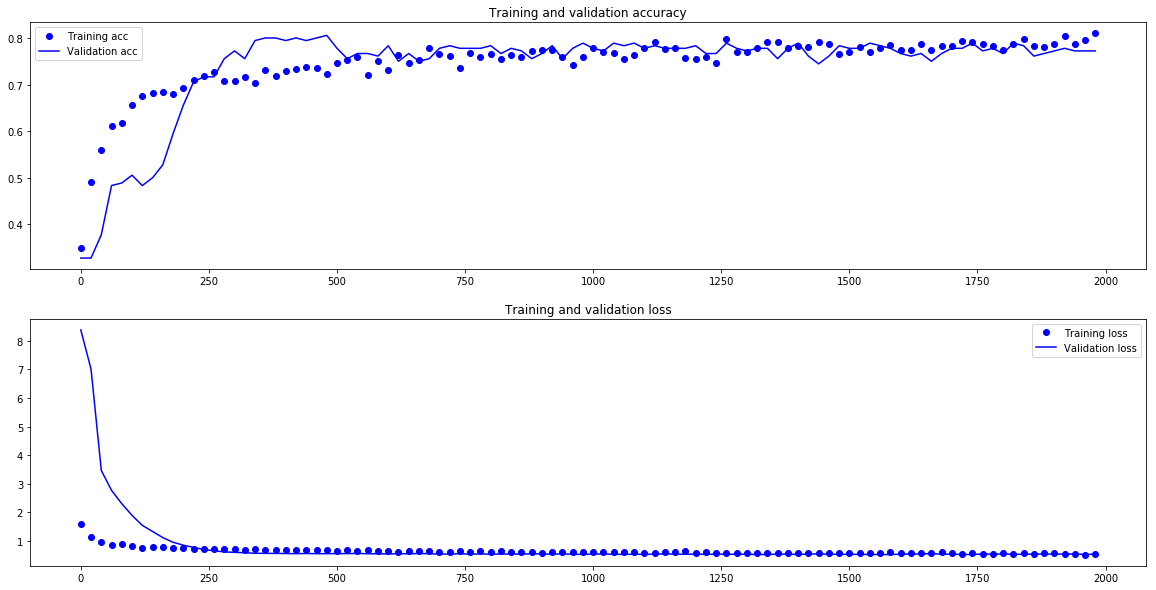

In [20]:
plot_history(history)

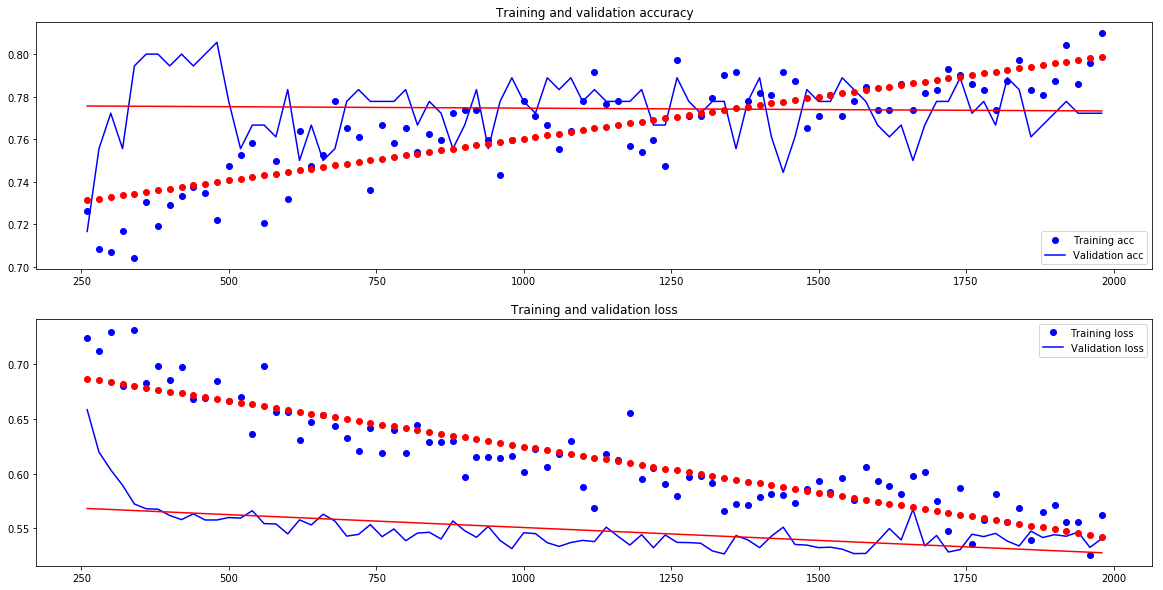

In [21]:
plot_history(history, init_phase_samples=250, plot_line=True)

### Scores around 80% look good now, there might even be a bit more potential here, but we are not going after a final percent here

## We now seem to have a decent model, so we save it for the next steps

In [22]:
model.save('insurance.hdf5')

In [23]:
# the model has a decent size as we only have a little more than 10.000 parameters
!ls -l insurance.hdf5

-rw-r--r-- 1 olive 197609 179704 Sep 14 09:10 insurance.hdf5
